We will reproduce the results for $P$-$B_L$ relationship using ERA5 and IMERG


In [1]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib
import datetime as dt
from dateutil.relativedelta import relativedelta

### Get $P$-$B_L$ from IMERG-ERA5 

In [22]:

date=dt.datetime(2016,1,1)
cwv_ocn=[]
crh_ocn=[]
thetae_bl_test=[]
thetae_lt_test=[]
thetae_sat_lt_test=[]
prc_test=[]

while date<=dt.datetime(2016,1,30):

    print(date)

    if date==dt.datetime(2016,1,3):
        date+=relativedelta(days=1)
        continue

    fil='/neelin2020/ML_input/thermo1/era5_condensed_thermo1_{}.npz'.format(date.strftime("%Y_%m_%d"))
    f=np.load(fil,'r')
    cwv_ocn.append(f['cwv_ocn'])
    crh_ocn.append(f['crh_ocn'])
    f.close()


    fil='/neelin2020/ML_input/thermo2/era5_condensed_thermo2_{}.npz'.format(date.strftime("%Y_%m_%d"))
    f=np.load(fil,'r')
    thetae_bl_test.append(f['thetae_bl_ocn'])
    thetae_lt_test.append(f['thetae_lt_ocn'])
    thetae_sat_lt_test.append(f['thetae_sat_lt_ocn'])
    f.close()

    fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_{}.npz'.format(date.strftime("%Y_%m_%d"))
    f=np.load(fil,'r')
    prc_test.append(f['prc_ocn'])
    f.close()
    
    date+=relativedelta(days=1)




2016-01-01 00:00:00
2016-01-02 00:00:00
2016-01-03 00:00:00
2016-01-04 00:00:00
2016-01-05 00:00:00
2016-01-06 00:00:00
2016-01-07 00:00:00
2016-01-08 00:00:00
2016-01-09 00:00:00
2016-01-10 00:00:00
2016-01-11 00:00:00
2016-01-12 00:00:00
2016-01-13 00:00:00
2016-01-14 00:00:00
2016-01-15 00:00:00
2016-01-16 00:00:00
2016-01-17 00:00:00
2016-01-18 00:00:00
2016-01-19 00:00:00
2016-01-20 00:00:00
2016-01-21 00:00:00
2016-01-22 00:00:00
2016-01-23 00:00:00
2016-01-24 00:00:00
2016-01-25 00:00:00
2016-01-26 00:00:00
2016-01-27 00:00:00
2016-01-28 00:00:00
2016-01-29 00:00:00
2016-01-30 00:00:00


In [24]:
concat=lambda x:np.concatenate(x)

list1=list(map(concat,[thetae_bl_test,thetae_lt_test,
                  thetae_sat_lt_test,cwv_ocn,crh_ocn,prc_test]))
thetae_bl_test,thetae_lt_test,thetae_sat_lt_test,cwv_ocn,crh_ocn,prc_test=list1
### remove zero values from input array

ind_nonzero=np.where(thetae_bl_test>0)

remove_zeros=lambda x,ind:x[ind]
list1=list(map(remove_zeros,[thetae_bl_test,thetae_lt_test,
                  thetae_sat_lt_test,cwv_ocn,crh_ocn,prc_test],itertools.repeat(ind_nonzero)))

thetae_bl_test,thetae_lt_test,thetae_sat_lt_test,cwv_ocn,crh_ocn,prc_test=list1

In [26]:
wb=0.5
cape=(thetae_bl_test-thetae_sat_lt_test)/thetae_sat_lt_test
subsat=(thetae_sat_lt_test-thetae_lt_test)/thetae_sat_lt_test
BL=cape*wb-(1-wb)*subsat
BL*=340

In [27]:
np.nanmax(cwv_ocn)

84.97474265656017

In [28]:
BL_bins=np.arange(-40,5.,1.)
pcp_bins=2**(np.arange(-2.,8.125,0.125))
pcp_bins=np.insert(pcp_bins,0,1e-3)
pcp_bins=np.insert(pcp_bins,0,0)

prc_bin_centers=(pcp_bins[1:]+pcp_bins[:-1])*0.5
def bin_prc_bl(prc,BL,BL_bins):

    BL_indx=np.int_((BL-BL_bins[0])/np.diff(BL_bins)[0])
    
    prc_bl_binned=np.zeros((BL_bins.size))
    bl_pdf_binned=np.zeros((BL_bins.size))
    prc_bl_joint=np.zeros((BL_bins.size,pcp_bins.size-1))

    for i in np.arange(BL_bins.size):
        indx=np.where(BL_indx==i)[0]
        if indx.size>100:
            prc_bl_binned[i]=prc[indx].mean()
        else:
            prc_bl_binned[i]=np.nan
        bl_pdf_binned[i]=indx.size
        prc_bl_joint[i,:]=np.histogram(prc[indx],bins=pcp_bins)[0]
        
    return [prc_bl_binned,bl_pdf_binned,prc_bl_joint]


cwv_bins=np.arange(2.,82.,2.)
crh_bins=np.arange(0.1,1.025,0.025)

In [29]:
prc_bl_binned,bl_pdf_binned,prc_bl_joint=bin_prc_bl(prc_test,BL,BL_bins)
prc_cwv_binned,cwv_pdf_binned,prc_cwv_joint=bin_prc_bl(prc_test,cwv_ocn,cwv_bins)
prc_crh_binned,crh_pdf_binned,prc_crh_joint=bin_prc_bl(prc_test,crh_ocn,crh_bins)

### Obs. baseline

In [30]:
# date=dt.datetime(2016,1,1)
# prc_list=[]
# while date<=dt.datetime(2016,1,30):
#     fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_{}.npz'.format(date.strftime("%Y_%m_%d"))
#     f=np.load(fil,'r')
#     prc_list.append((f['prc_ocn']))
    
#     f.close()
#     date+=relativedelta(days=1)
    

# prc_array=np.asarray([j for i in prc_list for j in i])

In [31]:
prc_pdf=np.histogram(prc_test,bins=pcp_bins)[0]
prc_pdf=prc_pdf/(np.diff(pcp_bins)*prc_pdf.sum())

In [50]:
prc_bl_binned[bl_pdf_binned>100]

array([8.91450428e-05, 1.90185366e-04, 4.54960509e-04, 3.86204742e-04,
       5.15753929e-04, 4.91021602e-04, 3.35323691e-04, 6.74708414e-04,
       6.45146953e-04, 5.93980384e-04, 5.51963085e-04, 4.46009505e-04,
       7.03679696e-04, 5.94156756e-04, 7.16724404e-04, 8.48403156e-04,
       6.80701498e-04, 8.96455463e-04, 1.06948428e-03, 1.30513723e-03,
       1.72856249e-03, 2.24434599e-03, 3.11115350e-03, 4.05507668e-03,
       5.34737451e-03, 7.15966757e-03, 9.40356736e-03, 1.24752582e-02,
       1.61683571e-02, 2.07820243e-02, 2.81673479e-02, 3.77088379e-02,
       5.44212393e-02, 7.68339689e-02, 1.10192415e-01, 1.62400735e-01,
       2.49612696e-01, 4.18033786e-01, 7.82911717e-01, 1.48740129e+00,
       2.70864365e+00, 4.22963204e+00, 5.93182812e+00, 4.42056729e+00])

/tmp/ipykernel_213286/3515237581.py:10: RuntimeWarning: divide by zero encountered in log10
  z=np.log10(pdf_norm.T)


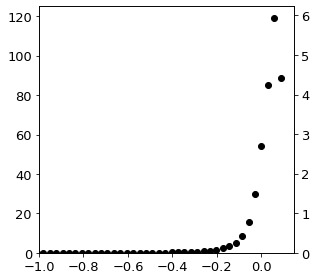

In [110]:
FACTOR=9.8/340.
fig,axx=plt.subplots(1,1,figsize=(4.5,4.))


ax=axx
pdf_norm=prc_bl_joint/(prc_bl_joint.sum()*np.diff(pcp_bins)*np.diff(BL_bins)[0])



z=np.log10(pdf_norm.T)

# CT=ax.pcolormesh(BL_bins*FACTOR,(pcp_bins[1:]+pcp_bins[:-1])*0.5,
#            z,cmap=plt.get_cmap('YlOrRd'),
#                  vmax=0.0,vmin=-9.)


# cax=fig.add_axes([-.05,0.15,0.025,0.7])
# CB=plt.colorbar(CT,cax=cax)
# CB.ax.tick_params(labelsize=14)
ax.set_ylim(top=125)
ax.tick_params(which='both',labelsize=13)


# ax.set_yticklabels([])
# ax.set_yticks([])


ax2=ax.twinx()
ax2.scatter(BL_bins[bl_pdf_binned>100]*FACTOR,
            prc_bl_binned[bl_pdf_binned>100],color='black')
ax2.set_ylim(bottom=0)
ax2.tick_params(which='both',labelsize=13)
# ax.set_ylabel('Precip. (mm/hr)',fontsize=13)
ax2.set_xlim(left=-1)


# ax.set_xlabel('$B_L$ $(\mathrm{ms^{-2}})$',fontsize=14)



# ax=axx[1]
# ax.scatter(pcp_bins[:-1],prc_pdf,color='blue')
# ax.set_yscale('log')
# ax.set_xlim(0,1.25e2)
# ax.tick_params(which='both',labelsize=13)
# ax.set_xlabel('Precip. (mm/hr)',fontsize=13)
# ax.set_title('Precipitation pdf',fontsize=14)

plt.tight_layout()
SAVE=True
if SAVE:
    plt.savefig('/home/fiaz/ML/precip_mapping/plots/P-B_IMERG_wo_joint_pdf.pdf',format='pdf',bbox_inches='tight')

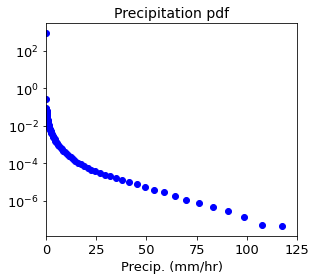

In [72]:
FACTOR=9.8/340.
fig,axx=plt.subplots(1,1,figsize=(4.5,4.))



ax=axx

ax.scatter(pcp_bins[:-1],prc_pdf,color='blue')
ax.set_yscale('log')
ax.set_xlim(0,1.25e2)
ax.tick_params(which='both',labelsize=13)
ax.set_xlabel('Precip. (mm/hr)',fontsize=13)
ax.set_title('Precipitation pdf',fontsize=14)

plt.tight_layout()
SAVE=True
if SAVE:
    plt.savefig('/home/fiaz/ML/precip_mapping/plots/IMERG_precip_pdf.pdf',format='pdf',bbox_inches='tight')

In [ ]:
np.save('prc_pdf.npy',prc_pdf)

/tmp/ipykernel_213286/1886601393.py:19: RuntimeWarning: divide by zero encountered in log10
  np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'),vmax=0.0,vmin=-7.5)


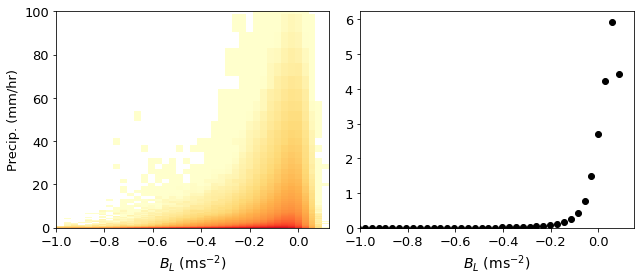

In [111]:
FACTOR=9.8/340.
fig,axx=plt.subplots(1,2,figsize=(9.,4.))

# ax=axx[0]
# ax.scatter(BL_bins*FACTOR,prc_bl_binned,color='blue')
# ax.set_ylim(bottom=0)
# ax.tick_params(which='both',labelsize=13)

# ax2=ax.twinx()
# pdf=bl_pdf_binned/(bl_pdf_binned.sum()*np.diff(BL_bins)[0])
# ax2.scatter(BL_bins*FACTOR,pdf,color='black')
# ax2.tick_params(which='both',labelsize=13)
# ax2.set_yscale('log')

ax=axx[0]
pdf_norm=prc_bl_joint/(prc_bl_joint.sum()*np.diff(pcp_bins)*np.diff(BL_bins)[0])

CT=ax.pcolormesh(BL_bins*FACTOR,(pcp_bins[1:]+pcp_bins[:-1])*0.5,
           np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'),vmax=0.0,vmin=-7.5)


# cax=fig.add_axes([-.05,0.15,0.025,0.7])
# CB=plt.colorbar(CT,cax=cax)
# CB.ax.tick_params(labelsize=14)
ax.set_ylim(top=100)



ax2=axx[1]
ax2.scatter(BL_bins*FACTOR,prc_bl_binned,color='black')
ax2.set_ylim(bottom=0)
ax2.tick_params(which='both',labelsize=13)
ax.set_ylabel('Precip. (mm/hr)',fontsize=13)
ax.set_xlabel('$B_L$ $(\mathrm{ms^{-2}})$',fontsize=14)
ax2.set_xlim(left=-1)
ax2.set_xlabel('$B_L$ $(\mathrm{ms^{-2}})$',fontsize=14)
ax2.tick_params(which='both',labelsize=13)
ax.tick_params(which='both',labelsize=13)
ax.set_xlim(left=-1)



plt.tight_layout()
SAVE=False
if SAVE:
    plt.savefig('/home/fiaz/ML/plots/P-B_IMERG_separate.pdf',format='pdf',bbox_inches='tight')

In [112]:
np.log10(pdf_norm)

/tmp/ipykernel_213286/547329320.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(pdf_norm)


array([[-0.96084076, -5.52772082,        -inf, ...,        -inf,
               -inf,        -inf],
       [-1.02228928, -5.50572653,        -inf, ...,        -inf,
               -inf,        -inf],
       [-0.78943221, -5.23236796,        -inf, ...,        -inf,
               -inf,        -inf],
       ...,
       [-2.01888166, -4.37718367, -4.52137955, ...,        -inf,
               -inf,        -inf],
       [-3.07352953, -5.83442795, -5.7705779 , ...,        -inf,
               -inf,        -inf],
       [-5.0180122 , -7.41421155,        -inf, ...,        -inf,
               -inf,        -inf]])

/tmp/ipykernel_213286/2301706640.py:24: RuntimeWarning: divide by zero encountered in log10
  np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'),vmax=0.2)


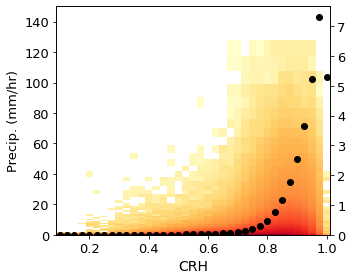

In [117]:
FACTOR=9.8/340.
fig,axx=plt.subplots(1,1,figsize=(5.,4.))


# ax=axx[0]
# pdf_norm=prc_cwv_joint/(prc_cwv_joint.sum()*np.diff(pcp_bins)*np.diff(cwv_bins)[0])
# CT=ax.pcolormesh(cwv_bins,(pcp_bins[1:]+pcp_bins[:-1])*0.5,
#            np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'))

# ax.set_ylim(top=100)
# ax.tick_params(which='both',labelsize=13)
# ax2=ax.twinx()
# ax2.scatter(cwv_bins,prc_cwv_binned,color='black')
# ax2.set_ylim(bottom=0)
# ax2.tick_params(which='both',labelsize=13)
# ax.set_ylabel('Precip. (mm/hr)',fontsize=13)
# ax.set_xlabel('$B_L$ $(\mathrm{ms^{-2}})$',fontsize=14)
# ax2.set_xlim(left=-1)


ax=axx
pdf_norm=prc_crh_joint/(prc_crh_joint.sum()*np.diff(pcp_bins)*np.diff(crh_bins)[0])
CT=ax.pcolormesh(crh_bins,(pcp_bins[1:]+pcp_bins[:-1])*0.5,
           np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'),vmax=0.2)

ax.set_ylim(top=150)
ax.tick_params(which='both',labelsize=13)
ax2=ax.twinx()
ax2.scatter(crh_bins,prc_crh_binned,color='black')
ax2.set_ylim(bottom=0)
ax2.tick_params(which='both',labelsize=13)
ax.set_ylabel('Precip. (mm/hr)',fontsize=13)
ax.set_xlabel('CRH',fontsize=14)
# ax2.set_xlim(left=-1)

plt.tight_layout()
SAVE=True
if SAVE:
    plt.savefig('/home/fiaz/ML/precip_mapping/plots/P-crh_IMERG_joint_pdf.pdf',format='pdf',bbox_inches='tight')

In [ ]:
### Sigmoid

In [ ]:
sigmoid=lambda x:np.exp(x)/(1+np.exp(x))

In [ ]:
x=np.arange(-10,10.5,0.5)
fig,axx=plt.subplots(1,1,figsize=(5,2.5))
ax=axx
ax.plot(x,sigmoid(x),color='blue',linewidth=13)
ax.set_xticks([])
ax.tick_params('both',labelsize=12)
ax.set_yticks([])
ax.axis('off')
SAVE=True
if SAVE:
    plt.savefig('/home/fiaz/ML/plots/sigmoid.pdf',format='pdf',bbox_inches='tight')